In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from skimage.transform import probabilistic_hough_line
import cv2

import warnings
warnings.filterwarnings("ignore")

In [316]:
%matplotlib inline

# xyz format is separated by spaces
df = pd.read_csv('./data/xyzs/patron_1.xyz', sep=' ')

# we don't need any columns beyond the first three
# as these are artefacts
df = df.drop(df.columns[3:], axis=1)
mat = df.to_numpy()

mu = np.mean(mat, axis=0)
mat = mat - mu

# swapping the y and z axes means the ceiling is oriented correctly
mat[:, [1, 2]] = mat[:, [2, 1]]

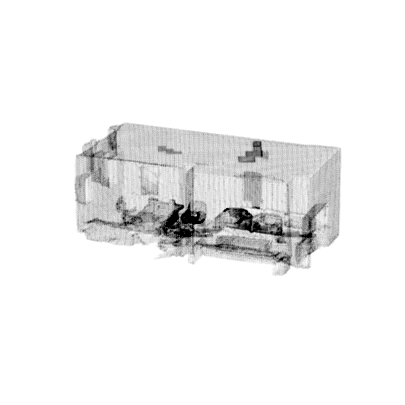

In [349]:
fig = plt.figure()
fig.set_figheight(5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mat[:,0], mat[:,1], mat[:,2], c='k', alpha=0.002, s=1)
ax.set_aspect('equal', adjustable='box')

# At a right angle, we the walls are at an angle
ax.view_init(elev=20, azim=90)
plt.axis('off')
plt.savefig('plots/boss_room_angle', bbox_inches='tight')
plt.show()

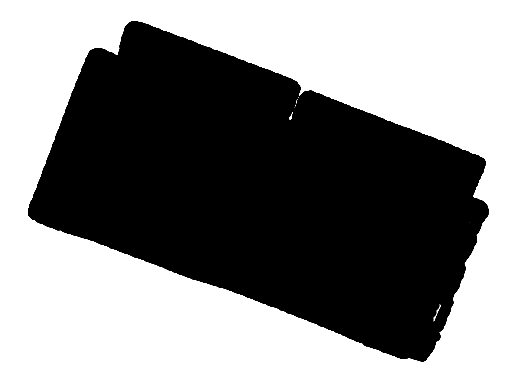

In [318]:
# Sorting in terms of height of points, we take the top 60% to avoid noise
ceil = mat[mat[:, 2].argsort()][int(mat.shape[0]*0.6):,:]

# Only take x and y dimensions
ceil = ceil[:,:2]

# To implement line detection, we must split thedata into voxels. 
# The easiest way to do this is to plot a graph
fig, ax = plt.subplots(1)
ax.scatter(ceil[:,0], ceil[:, 1], color='k')
ax.set_aspect('equal', 'box')
ax.axis('off')

# Writes the changes
fig.canvas.draw()

# Supress popup
plt.ioff()

# Turn plot into a np matrix
img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [321]:
# Blur any noise using a 9x9 kernel
blur = cv2.GaussianBlur(img, (15, 15), 0)

# Take only the sharpest edges
edge = cv2.Canny(blur, 200, 300)

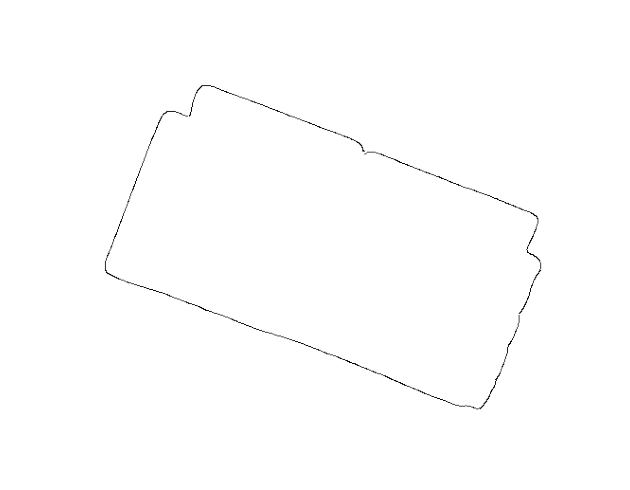

In [351]:
fig = plt.figure()
fig.set_figheight(5)
plt.imshow(edge, cmap='Greys')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig('plots/edge', bbox_inches='tight')
plt.show()

In [364]:
# Using the Hough transform, we can detect the lines in this image.
# These lines are represented by two (x, y) pairs
lines = probabilistic_hough_line(edge, threshold=0, line_length=1, line_gap=10)

# Find the vector gradients of the lines 
# (e.g. y = [1 2] + y * [0 1] for a vertical line passing through [1 2])
grad = np.array([[(i[1][0]-i[0][0]),(i[1][1]-i[0][1])] for i in lines])

# Use l2 normalisation for each vector gradient
norms = np.linalg.norm(grad, axis=1)[:, np.newaxis]
norms = np.tile(norms, (1, 2))

# Divide both components of the vector elementwise
grad = grad / norms

# Potential outlier detection, assuming all walls are perpendicular to x, y axes
# outlier_idx = np.logical_and(grad[:,0] > 0.4, grad[:,1] > 0.4)

# First and second point that make up each line
arr0 = np.array(([[i[0][0],i[0][1]] for i in lines]))
arr1 = np.array([[i[1][0],i[1][1]] for i in lines])

# grad, arr1, arr2 = grad[~outlier_idx], arr1[~outlier_idx], arr2[~outlier_idx]

# Stack them into a (len(arr0) + len(arr1)) x 2 matrix
points = np.vstack((arr0, arr1))
p_mean = np.mean(points, axis=0)
points = points - p_mean

# Using K-Means we split the lines into two groups for perpendicular walls
km = KMeans(n_clusters=2).fit(grad)

# Returns a list of 0/1s corresponding to the group each gradient is assigned
labels = km.labels_

# Append to each (x, y) pair the labels. 
labelled_grad = np.hstack((grad, labels[:, np.newaxis]))

# The start and end points of the lines will have the same classification,
# so the labels are repeated
labelled_points = np.hstack((points, np.hstack((labels,labels))[:, np.newaxis]))
# For the two groups
d = [{},{}]

# The first and second new orthonormal basis vector (compared to [1 0] and [0 1])
b0 = np.median(labelled_grad[labelled_grad[:,2] == 0.][:,:2], axis=0)
b1 = np.array([1, -b0[0] / b0[1]])
b1 = b1 / np.linalg.norm(b1)
d[0]['b'], d[1]['b'] = b0, b1

# Classify the points into two groups
d[0]['points'], d[1]['points'] = (labelled_points[labelled_points[:,2] == i][:,:2] for i in range(2))

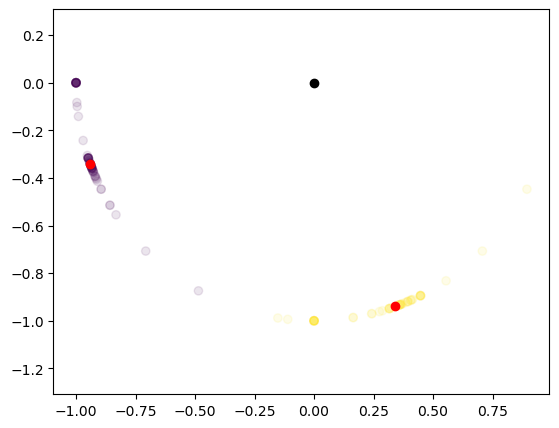

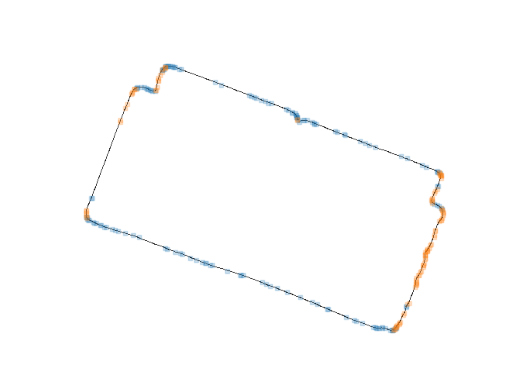

In [365]:
fig = plt.figure().set_figheight(5)
plt.scatter(grad[:,0], grad[:,1], c=labels, alpha=0.1)
plt.scatter(b0[0], b0[1], c='r')
plt.scatter(b1[0], b1[1], c='r')
plt.scatter(0, 0, c='k')
plt.axis('equal')
plt.savefig('plots/orthonormal_basis', bbox_inches='tight')
plt.show()

fig = plt.figure().set_figheight(5)
for i in range(2):
    plt.scatter(d[i]['points'][:,0] + p_mean[0], d[i]['points'][:,1] + p_mean[1], marker='s', s=10, alpha=0.2)
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.savefig('plots/classified_points', bbox_inches='tight')
plt.show()

In [366]:
# Now that we know the bases/ eigenvectors, we can rotate the 3d point cloud
# axis of rotation = z axis
# normal of wall (without loss of generality) = [b0[0] b0[1] 0]

basis = np.array([1, 0, 0])

# Normal of fitted plane
norm = np.array([b0[0], b0[1], 0])
# Normalise the normal
norm = norm / np.linalg.norm(norm)

angle = -np.arccos(np.dot(norm, basis))



# Find axis of rotation perpendicular to norm and basis_x
axis = np.array([0, 0, 1])
# axis = axis / np.linalg.norm(axis)

# Use Rodrigues rotation formula to calculate rotation matrix
C = np.array([[0, -axis[2], axis[1]],
            [axis[2], 0, -axis[0]],
            [-axis[1], axis[0], 0]])
rot_mat =  np.identity(3) + np.sin(angle)*C + (1-np.cos(angle))*np.dot(C, C)
rot_mat_2d = np.array([[np.cos(angle), -np.sin(angle)],
                       [np.sin(angle), np.cos(angle)]])
# Rotate each point
new_mat = np.dot(rot_mat, mat.T).T
for i in range(2):

    # Cardinal bases in the form of [1 0], [0 1]
    d[i]['new_b'] = np.uint8(np.round(np.dot(d[i]['b'], rot_mat_2d)))

    # Along which axes do the points vary
    idx = np.argmin(d[i]['new_b'])

    # Transform points
    rotated = np.dot(d[i]['points'], rot_mat_2d)

    # Sort the rotated points
    d[i]['rotated'] = rotated[rotated[:, idx].argsort()]

    # Remove extra dimension
    d[i]['1d'] = d[i]['rotated'][:, idx]

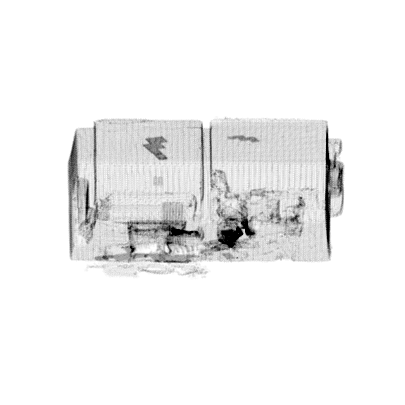

In [371]:
fig = plt.figure()
fig.set_figheight(5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_mat[:,0], new_mat[:,1], new_mat[:,2], c='k', alpha=0.002, s=1)
ax.set_aspect('equal', adjustable='box')

# At a right angle, we the walls are at an angle
ax.view_init(elev=20, azim=90)
plt.axis('off')
plt.savefig('plots/rotated_room', bbox_inches='tight')
plt.show()


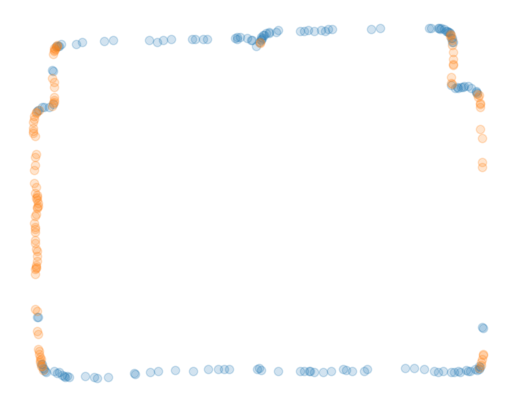

In [368]:

fig = plt.figure().set_figheight(5)
for i in range(2):
    plt.scatter(d[i]['rotated'][:,0], d[i]['rotated'][:,1], alpha=0.2)
plt.axis('off')
plt.show()

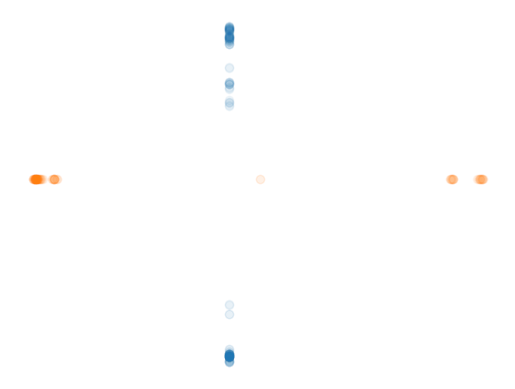

In [377]:
for i in range(2):
    mult = np.tile(np.abs(d[i]['new_b'] - 1), (len(d[i]['rotated']), 1))
    s = d[i]['rotated'] * mult
    plt.scatter(s[:,0], s[:,1], alpha=0.05)
plt.axis('off')
plt.savefig('plots/one_dim', bbox_inches='tight')
plt.show()
    

In [370]:
def cluster_1d(d, eps=2, n_thresh=3):

    # For each side
    for n in range(2):

        # Points of current side
        curr_points = d[n]['1d']
        curr_label = 0
        labels = np.zeros_like(curr_points)

        for i, j in enumerate(curr_points[:-1]):

            # If the next point is closer than eps units, it receives the same label
            if j + eps >= curr_points[i+1]:
                labels[i+1] = curr_label
            else:
                curr_label += 1
                labels[i+1] = curr_label
        n_labels = 0

        # Separate into clusters by label
        for i in range(curr_label+1):
            cluster = d[n]['rotated'][labels == float(i),:]
            
            # Only clusters with n_points greater than threshold remain to filter out noise
            if cluster.shape[0] > n_thresh:
                d[n][f'{n_labels}'] = cluster
                s = np.mean(cluster, axis=0)
                d[n][f's{n_labels}'] = s
                n_labels += 1
        d[n]['n'] = n_labels
    return d
d = cluster_1d(d)
print([d[i].keys() for i in range(2)])

[dict_keys(['b', 'points', 'new_b', 'rotated', '1d', '0', 's0', '1', 's1', '2', 's2', '3', 's3', 'n']), dict_keys(['b', 'points', 'new_b', 'rotated', '1d', '0', 's0', '1', 's1', '2', 's2', '3', 's3', 'n'])]


In [372]:
# For appending to
corners = np.zeros((1, 2))

# Linearly solve to find all possible intersections
a = np.vstack((d[0]['new_b'], -d[1]['new_b']))
for i in range(d[0]['n']):
    for j in range(d[1]['n']):

        # a * lam = b
        b = d[0][f's{i}'] - d[1][f's{j}']

        # vector of parameters
        lam = np.linalg.solve(a, b[:, np.newaxis])

        # Reconstruct Cartesian point
        x0 = d[0][f's{i}'] - lam[0] * d[0]['new_b']

        # Append to previous corners
        corners = np.vstack((corners, x0[np.newaxis, :]))
corners = corners[1:,:]
norm_corn = (corners - np.min(corners))

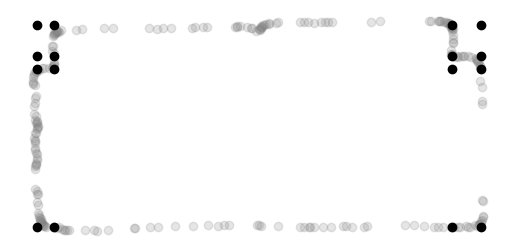

In [374]:

fig = plt.figure().set_figheight(3)
for i in range(2):
    plt.scatter(d[i]['rotated'][:,0], d[i]['rotated'][:,1], alpha=0.2, c='0.5')
    for j in range(d[i]['n']):
        f = d[i][f's{j}']
plt.scatter(corners[:,0], corners[:,1], c='k')
plt.axis('off')
plt.savefig('plots/with_corners', bbox_inches='tight')
plt.show()

In [384]:
n_bins = 100
dims = np.zeros(2)

x, y = new_mat[:, 0], new_mat[:, 1]

for i, j in enumerate([y, x]):

    # Interval in which bins are located
    interval = np.min(j), np.max(j)
    bins = np.linspace(*interval, n_bins)

    # Take midpoint of each bin
    midpoints = (bins[1:] + bins[:-1]) / 2

    # Find which midpoints are greater than 0
    pos = midpoints > 0

    # Count per bin
    counts, _ = np.histogram(j, bins, density=True)

    # For each side of the number line
    ub, lb = midpoints[pos][np.argmax(counts[pos])], midpoints[~pos][np.argmax(counts[~pos])]
    dims[i] = ub - lb
dims

array([3.74314508, 7.08169256])

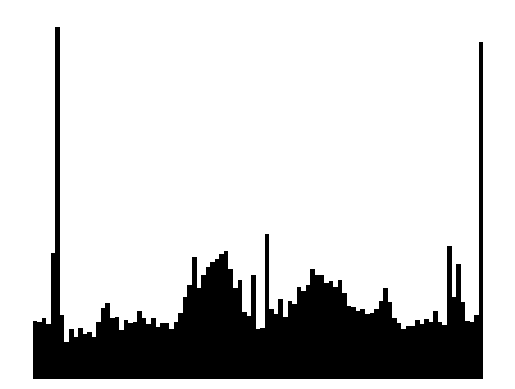

In [386]:
plt.bar(np.arange(len(counts)), counts, color='k', width=1)
plt.axis('off')
plt.savefig('plots/along_x_hist', bbox_inches='tight')
plt.show()

In [376]:
factor = np.mean(np.ptp(norm_corn, axis=0) / dims)
np.round(norm_corn / factor, 2)

array([[0.  , 1.1 ],
       [0.29, 1.1 ],
       [6.73, 1.1 ],
       [7.2 , 1.1 ],
       [0.  , 3.99],
       [0.29, 3.99],
       [6.73, 3.99],
       [7.2 , 3.99],
       [0.  , 4.22],
       [0.29, 4.22],
       [6.73, 4.22],
       [7.2 , 4.22],
       [0.  , 4.78],
       [0.29, 4.78],
       [6.73, 4.78],
       [7.2 , 4.78]])